In [1]:
#Instantiate SparkSession
from pyspark.sql import SparkSession
spark=SparkSession \
.builder \
.appName('Effects of Dimensionality Reduction when making predictions') \
.getOrCreate()

In [2]:
# wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
# gsutil cp day.csv gs://dexdebra-123/datasets
# Use sparkSession to read csv file

rawdata=spark.read \
           .format('csv') \
           .option('header','true') \
           .load('gs://dexdebra-123/datasets/day.csv')

In [6]:
rawdata.toPandas().head()

# casual|registered|cnt
# used to predict the number of bike rentals based on weather and season information


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


In [7]:
# Setup Dataframe with only the columns we are interested

from pyspark.sql.functions import col

dataset=rawdata.select(
                    col('season').cast('float'),
                    col('yr').cast('float'),
                    col('mnth').cast('float'),
                    col('holiday').cast('float'),
                    col('weekday').cast('float'),
                    col('workingday').cast('float'),
                    col('weathersit').cast('float'),
                    col('temp').cast('float'),
                    col('atemp').cast('float'),
                    col('hum').cast('float'),
                    col('windspeed').cast('float'),
                    col('cnt').cast('float')
)

# We left cols which had a count of casual and registered
# we are only interested in total count of bike rentals

In [8]:
dataset.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0


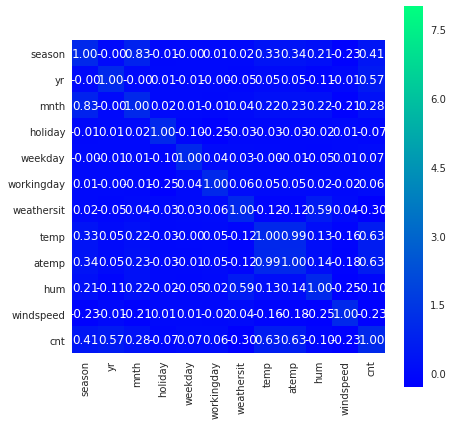

In [100]:
# The values in two or more columns may by highly correlated with one another
# In such situations we  want to use only one of the two columns
# In order to see correlations between columns we can use heatmap feature in seaborn visualizing ibrary
# Generally, ML algorithms will not work well, when there are huge number of columns with correlated data
# Ideally, data should be un-correlated
# That is , whey PCA is so useful.

import matplotlib.pyplot as plt
import seaborn as sns

corrmat=dataset.toPandas().corr()
plt.figure(figsize=(7,7))
sns.set(font_scale=1.0)
sns.heatmap(corrmat,vmax=8,square=True,annot=True,fmt='.2f',cmap="winter")
plt.show()

#Season and Month are correlated
#temp and atemp are correlated
#weathersit and hum are highly correlated



In [12]:
featuresCols = dataset.columns
featuresCols.remove('cnt')
featuresCols


['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [13]:
# Use VectorAssembler to pull all the features into a single column
from pyspark.ml.feature import VectorAssembler

assembler=VectorAssembler(
        inputCols=featuresCols, outputCol='features'
)

In [14]:
# Pass the input dataset to assembler and create a new dataframe with features column		
vectorDF=assembler.transform(dataset)

vectorDF.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.34416699..."
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.36347800..."
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.19636400..."
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.20000000..."
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.22695699..."


In [16]:
len(featuresCols)

11

In [17]:
(trainingData,testingData) =vectorDF.randomSplit(
    [
    0.8,
    0.2
    ]
)

In [18]:
from pyspark.ml.regression import LinearRegression

lr=LinearRegression(
        maxIter=100,
        regParam=1.0,
        elasticNetParam=0.8,
        labelCol='cnt',
        featuresCol='features'
)

In [19]:
model=lr.fit(trainingData)

In [20]:

# Evaluate 
print('Training R2 Score=',model.summary.r2)
print('Training RMSE=',model.summary.rootMeanSquaredError)

('Training R2 Score=', 0.7968711382678648)
('Training RMSE=', 872.307736447617)


In [21]:
# We will use the model for prediction on our testData
# To See bike rental results
predictions=model.transform(testingData)
predictions.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features,prediction
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.096522,0.098839,0.436522,0.246600,986.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.09652169...",829.240341
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.19636400...",1569.864056
2,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.22695699...",2078.042973
3,1.0,0.0,1.0,0.0,4.0,1.0,2.0,0.261667,0.255050,0.538333,0.195904,1927.0,"[1.0, 0.0, 1.0, 0.0, 4.0, 1.0, 2.0, 0.26166701...",1544.581527
4,1.0,0.0,1.0,0.0,5.0,1.0,1.0,0.160870,0.188413,0.537826,0.126548,1421.0,"[1.0, 0.0, 1.0, 0.0, 5.0, 1.0, 1.0, 0.16087000...",1985.990701


In [24]:
# Evaluate  using RegressionEvaluator how model performs on TestData
from pyspark.ml.evaluation import RegressionEvaluator
evaluator=RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='r2'
)


In [25]:
r2=evaluator.evaluate(predictions)
print('Test R2 score= %g' % r2)

Test R2 score= 0.808322


In [26]:
rmse=evaluator.evaluate(predictions)
print('Test RMSE=',rmse)

('Test RMSE=', 0.8083217862774423)


In [27]:
predictionPandas=predictions.toPandas()

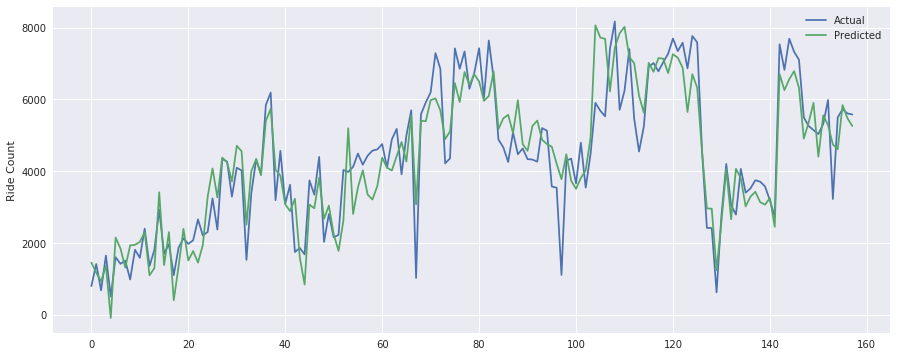

In [94]:
plt.figure(figsize=(15,6))
plt.plot(predictionPandas['cnt'],label='Actual')
plt.plot(predictionPandas['prediction'],label='Predicted')

plt.ylabel('Ride Count')
plt.legend()
plt.show()


In [28]:
from pyspark.ml.feature  import PCA

pca=PCA(
k=8, # 8 most important features
inputCol='features', 
outputCol='pcaFeatures'
)


In [29]:
# perform dimensionality reduction on our training data
pcaTransformer=pca.fit(vectorDF)

In [31]:
# Examing principal components that were generated using PCA Estimator
# They are available in pcaFeatures of the dataframe
pcaFeatureData=pcaTransformer.transform(vectorDF).select('pcaFeatures')
pcaFeatureData.toPandas().head()

,pcaFeatures
0,"[-1.299434105121149, -6.0002957882529495, 0.38..."
1,"[-1.256074046605141, -0.001809060927389727, 0...."
2,"[-1.2498374389125777, -1.0026992468169056, 0.5..."
3,"[-1.2589193782130974, -2.0018604800043343, 0.5..."
4,"[-1.2649515945734322, -3.0022673722336375, 0.5..."


In [32]:
pcaFeatureData.toPandas()['pcaFeatures'][0]

DenseVector([-1.2994, -6.0003, 0.3846, -2.024, 0.458, -0.4848, 0.569, -0.0731])

In [33]:
pcaTransformer.explainedVariance

DenseVector([0.7093, 0.2227, 0.0201, 0.0171, 0.0137, 0.0119, 0.0028, 0.0014])

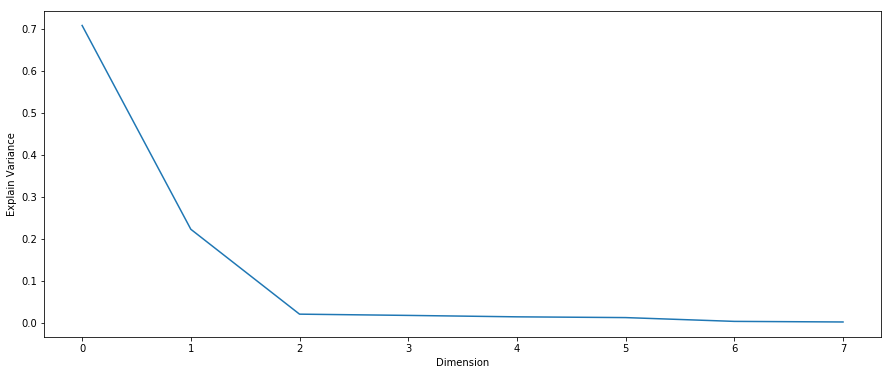

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(pcaTransformer.explainedVariance)
plt.xlabel('Dimension')
plt.ylabel('Explain Variance')
plt.show()


In [38]:
# There is a sharp drop-off in the importance of the features
# so these features are the ones that we want to use perform regression
# Which are these features?
# When we perform PCA ,it is like shifting the X-axis on the original feauture columns
# so that we can capture Maximum Variance in the underlying data
# Principal components by themselves do not have any feature columns associated with themselves
# We perform a join operation between the principal components and our original data which # contains actual bike rental counts 
# add a new 'row_index column' to each dataframe that will serve as ID field
# used to serve to join 2 tables,'PCA feature data' and 'vector data frame' 
# Special library: monotonically_increasing_id

from pyspark.sql.functions import monotonically_increasing_id
pcaFeatureData=pcaFeatureData.withColumn('row_index',monotonically_increasing_id())
vectorDF=vectorDF.withColumn('row_index',monotonically_increasing_id())

In [43]:
# Form a inner join operation on the two DataFrames and extract the columns we are interested
# cnt and pcaFeatures
# cnt fields is the label for our regression
# pcaFeatures form the features of our trainingData

transformedData = pcaFeatureData.join(vectorDF,on=['row_index']).\
                  sort('row_index'). \
                  select('cnt','pcaFeatures')
        
transformedData.toPandas().head()        

,cnt,pcaFeatures
0,985.0,"[-1.299434105121149, -6.0002957882529495, 0.38..."
1,801.0,"[-1.256074046605141, -0.001809060927389727, 0...."
2,1349.0,"[-1.2498374389125777, -1.0026992468169056, 0.5..."
3,1562.0,"[-1.2589193782130974, -2.0018604800043343, 0.5..."
4,1600.0,"[-1.2649515945734322, -3.0022673722336375, 0.5..."


In [48]:
# split dataset 80% traiing, 20% test data and
(pcaTrainingData,pcaTestData)=transformedData.randomSplit([0.8,0.2])

In [46]:
# Setup linear regression estimator
# pass 8-principalcomponents that we extracted from the underlying data as features

pcalr=LinearRegression(
maxIter=100,
regParam=1.0,
elasticNetParam=0.8,
labelCol='cnt',
featuresCol='pcaFeatures'
)


In [49]:
# train the regressionmodel on training data set
pcaModel=pcalr.fit(pcaTrainingData)

In [50]:
# Evaluate using r2 and RMSE
print('Training R2 Score= ', pcaModel.summary.r2)
print('Training RMSE = ',pcaModel.summary.rootMeanSquaredError)

('Training R2 Score= ', 0.7914308499148516)
('Training RMSE = ', 871.0575948947885)


In [52]:
# When we use the principal components our model does not perform as as well  on the training data
#as before
# Apply the regression model that has been trained on principal components to our test data
# which is also represented in the form of principalcomponents

pcaPredictions=pcaModel.transform(pcaTestData)
pcaPredictions.toPandas().head()

,cnt,pcaFeatures,prediction
0,801.0,"[-1.256074046605141, -0.001809060927389727, 0....",1401.532192
1,1606.0,"[-1.272914796510812, -4.00172387068543, 0.5902...",1893.694601
2,1248.0,"[-1.2941105474184946, -6.0016147215030395, 0.3...",1201.941680
3,683.0,"[-1.2684139691016256, -2.0097806901799657, 0.3...",1088.801944
4,1000.0,"[-1.258514927038901, -0.993819832623761, 0.301...",-44.188691


In [53]:
# Use RegressionEvaluator to check how well our model performs on test data
evaluator=RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='r2'
)

In [61]:
rsquare=evaluator.evaluate(pcaPredictions)
print("Test RMSE = %g" % rsquare)


Test R2 score = 950.638


In [60]:
# Use RegressionEvaluator to check how well our model performs on test data
evaluator=RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='rmse'
)

In [62]:
rmse=evaluator.evaluate(pcaPredictions)
print("Test R2 score = %g" % rmse)


Test R2 score = 950.638
